# House pricing prediction using shallow ANN and functional api in Keras: TensorFlow
- Multi-input, multi-output regression with wide and deep ANNs are implemented.  
- Possiblity of using a __subclass__ API is also dicussed towards the end.
- Using __callbacks__ method to save checkpoints and early termination of training is discussed.
- __TensorBoard__- for visualization is discussed.
- A section on __hyperparameter tuning__ like deciding on number of deep layers, no. of neutrons in each layer, etc.  
- This is a practice project where a shallow ANN is trained and  deployed for predicting **housing prices**  based on  the California Housing Prices dataset from the StatLib repository2. This dataset is based on data from the 1990 California census. 
- The project follows the suggestions from Chapter 10 of “Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition, by Aurélien Géron (O’Reilly). Copyright 2019 Kiwisoft S.A.S., 978-1-492-03264-9.” 


## Importing dependencies

In [1]:

import sys
assert sys.version_info >= (3, 5)

# TensorFLow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

#import Keras
from tensorflow import keras

# Common imports
import numpy as np
import pandas as pd
import os

# importing matplotlib for plotting and figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)
#making directory for saved models
os.makedirs("./saved_models",exist_ok=True)

def save_figure(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Loading data 
- For this example, we import the housing price data from scikit-learn.
- For more details on this data checkout _housing price example_ from _scikit_learn_projects_ folder in the main repository. Though, this data set is slightly simpler compared to the one used there, because the former only has numerical attributes and no categorical feature like ocean proximity.

In [2]:
#importing  data from scikit-learn package
from sklearn.datasets import fetch_california_housing
#importing tools to process the data before trainng
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing_data = fetch_california_housing()

#Splitting main data to training and test data
X_train_full, X_test_set, Y_train_full, Y_test_set =  train_test_split(
                            housing_data.data, housing_data.target)
#Splitting whole training data into main training set and validation set 
#for hyper parameter tuning
X_train_set, X_validn, Y_train_set, Y_validtn = train_test_split(
                            X_train_full, Y_train_full)

#function for scaling the data
def scalar_fun(scaling_func,arr):
    """
    [data_set1,..,data_setn] -> [scaled_dataset1,..,scaled_data_setn]
    """
    for data_set in arr:
        yield scaling_func.fit_transform(data_set)

scaler = StandardScaler()

X_train_set, X_validn, X_test_set = scalar_fun(scaler,
                                               (X_train_set, X_validn,
                                               X_test_set))


### Possibility of using Sequential API interface with Keras
- WE could use a shallow ANN with just one layer(becuase of the noise in the data an possible overfitting) as follows:
    ```
    seq_reg_model = keras.models.Sequential([  
                    keras.layers.Dense(30, activation="relu",  
                    input_shape=X_train.shape[1:]),  
                    keras.layers.Dense(1)  
                    ])
    ```
- But we stick to the functional api to see how it works.

## Regression using functional API

## Wide and deep ANNs
- To learn both deep patterns(through deep path) and simple patterns/rules(using short path)  
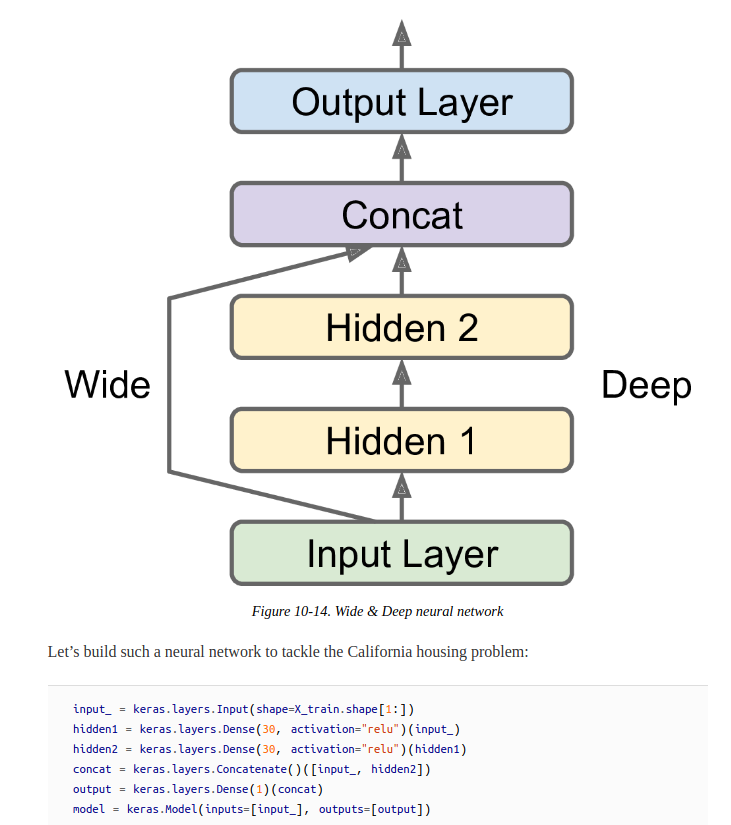

## Multi-input, multi-ouput model:
- Here we implement a multi-input, multi-output regression model.
- Some reasons to use multi input:
    - Give more weightage to only some part of the data.
- Some reasons to use multi output:
    - Locate and classify an object. This is classification and regression problem
    - Multiple independent tasks coming from same trained model.
    - Regularization technique: auxiliary outputs might help with preventing overfitting.
    

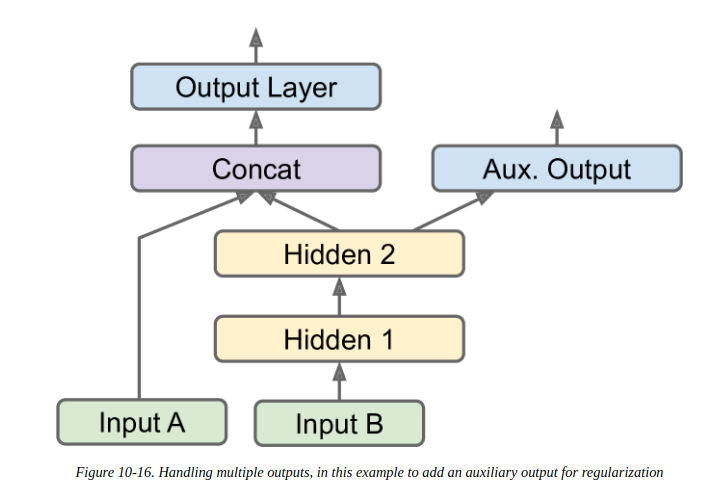

### Defining the model in Keras using functions API:

In [3]:
#definng the first wide input layer with first 5 features
input_A = keras.layers.Input(shape=[5], name="wide_input")
#definng the second deep  input layer with last six features
input_B = keras.layers.Input(shape=[6], name="deep_input")
#defining two deep layers in the deep network starting with input_B
hidden_1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden_2 = keras.layers.Dense(30, activation="relu")(hidden_1)
#concatenating the shallow(input_A) and deep(hidden2) networks
concat = keras.layers.concatenate([input_A, hidden_2])
#adding the main output layer of 1 neuron which corresponds to housing price
output = keras.layers.Dense(1, name="main_output")(concat)
#adding one extra auxiliary output
output_aux = keras.layers.Dense(1,name="aux_output")(hidden_2)
#Finally defining the model using functional api
func_model = keras.Model(inputs=[input_A, input_B], outputs=[output,output_aux])

## Compiling and training the model

### Compiling 
- Compiling model with mean squared erro as loss function for both outputs. 
- stoch gard descent as the optimizer alg with learning rate 1e-3(default is 1e-2).
- We also give a much more weightage(9:1) for output_A in terms of loss fuction

In [4]:
#compiling model with mean squared erro as loss function and 
#stoch gard descent as the optimizer alg with learning rate 1e-3(default is 1e-2)
func_model.compile(loss=["mse","mse"], loss_weights=[0.9,0.1],
                   optimizer=keras.optimizers.SGD(lr=1e-3))
print("modelcompilation successful")

modelcompilation successful


### Training the model 

In [5]:
#Defining input_A and input_B for training and validation set
X_train_A, X_train_B = X_train_set[:,:5], X_train_set[:,2:]
X_validn_A, X_validn_B = X_validn[:,:5], X_validn[:,2:]
X_test_A, X_test_B = X_test_set[:,:5], X_test_set[:,2:]

#Training the model
model_tr_hist = func_model.fit([X_train_A, X_train_B], [Y_train_set,Y_train_set],
                              epochs=20, validation_data=([X_validn_A, X_validn_B], 
                                                         [Y_validtn, Y_validtn]))

Epoch 1/20
363/363 [==============================] - 3s 7ms/step - loss: 2.5059 - main_output_loss: 2.3044 - aux_output_loss: 4.3192 - val_loss: 1.1429 - val_main_output_loss: 0.9162 - val_aux_output_loss: 3.1831
Epoch 2/20
363/363 [==============================] - 2s 6ms/step - loss: 0.9647 - main_output_loss: 0.7849 - aux_output_loss: 2.5828 - val_loss: 0.8145 - val_main_output_loss: 0.6764 - val_aux_output_loss: 2.0579
Epoch 3/20
363/363 [==============================] - 2s 6ms/step - loss: 0.7782 - main_output_loss: 0.6606 - aux_output_loss: 1.8369 - val_loss: 0.7160 - val_main_output_loss: 0.6195 - val_aux_output_loss: 1.5844
Epoch 4/20
363/363 [==============================] - 1s 4ms/step - loss: 0.7066 - main_output_loss: 0.6179 - aux_output_loss: 1.5047 - val_loss: 0.6695 - val_main_output_loss: 0.5929 - val_aux_output_loss: 1.3592
Epoch 5/20
363/363 [==============================] - 1s 4ms/step - loss: 0.6680 - main_output_loss: 0.5924 - aux_output_loss: 1.3481 - val_loss

### Testing the model on the test set

In [6]:
total_loss, main_loss, aux_loss = func_model.evaluate([X_test_A,X_test_B], [Y_test_set, Y_test_set])
print("total_loss={:.3f}, main_loss={:.3f}, aux_loss={:.3f}".format(total_loss,main_loss,aux_loss))

162/162 [==============================] - 0s 3ms/step - loss: 0.4910 - main_output_loss: 0.4489 - aux_output_loss: 0.8699
total_loss=0.491, main_loss=0.449, aux_loss=0.870


### Predicting on new data(coming from test set)


In [7]:
random_data_index = np.random.randint(0,X_test_A.shape[0])
random_input_A = X_test_A[random_data_index].reshape(1,5)
random_input_B = X_test_B[random_data_index].reshape(1,6)
y_pred_main, y_pred_aux = func_model.predict([random_input_A, 
                                                 random_input_B])
print(y_pred_main,y_pred_aux)

[[1.7591343]] [[2.236776]]


## Possiblity of using subclassing API to build more Dynamic models

### Advantages of using a statis API like sequential/functinal API
- You start by declaring which layers you want to use and how they should be connected, and only then can you start feeding the model some data for training or inference. This has many advantages: the model can easily be saved, cloned, and shared;
- its structure can be displayed and analyzed; 
- the framework can infer shapes and check types, so errors can be caught early (i.e., before any data ever goes through the model). 
- It’s also fairly easy to debug, since the whole model is a static graph of layers.

### Disadvantages of statis api:
- Some models involve loops, varying shapes, conditional branching, and other dynamic behaviors. For such cases, or simply if you prefer a more imperative programming style, the Subclassing API is for you.

Simply subclass the Model class, create the layers you need in the constructor, and use them to perform the computations you want in the call() method. For example, creating an instance of the following WideAndDeepModel class gives us an equivalent model to the one we just built with the Functional API. You can then compile it, evaluate it, and use it to make predictions, exactly like we just did:

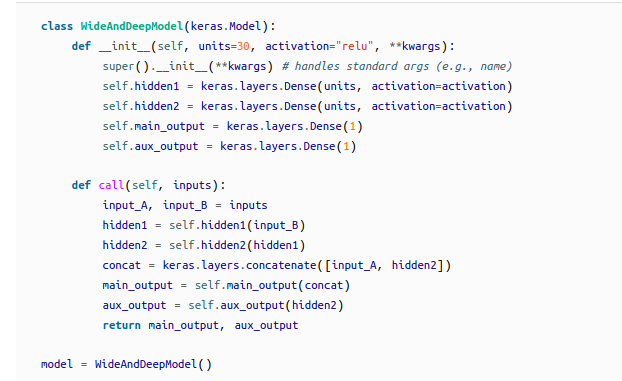
```
class WideAndDeepModel(keras.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs) # handles standard args (e.g., name)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)

    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel()
```
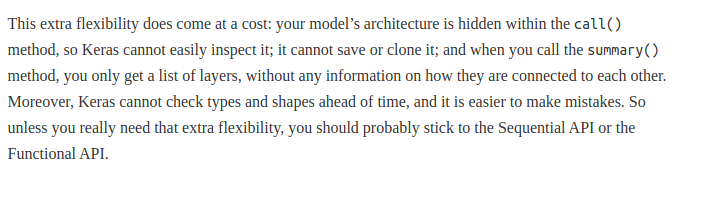

## Saving model

### Saving and loading model after complete training

In [8]:
#saving model
os.makedirs("./saved_models",exist_ok=True)
func_model.save("./saved_models/housing_pr_predictor.h5")

#loading model
my_model_loaded = keras.models.load_model("./saved_models/housing_pr_predictor.h5")

## Using Callbacks 
- fit() method takes callbacks argument which helps with saving checkpoints and early stoppage of the training.
- adding a `keras.callbacks.ModelCheckpoint("save_model.h5")` will store the model at each check point. At the end of each epoch by default.
- adding extra argument `save_best_only=True` save the model(parameters) with best accuracy on the validation set. Later we can use it to restore our final model to this model to prevent over training afterfull set of training.
- We can also use `keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)` to stop the trainng when there is no progress in subsequent epochs and restore weights to the best one(best accuracy on validation set). This allows us to use large number of epochs.

### Using Model checkpoints

In [9]:
#Defining a model for demo
input_ = keras.layers.Input(shape=X_train_set.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.Concatenate()([input_, hidden2])
output = keras.layers.Dense(1)(concat)
dummy_model = keras.Model(inputs=[input_], outputs=[output])
dummy_model.compile(loss="mse",
                   optimizer=keras.optimizers.SGD(lr=1e-2))

#Adding callback for model checkpoint with flag to save best model
checkpoint_cb_1 = keras.callbacks.ModelCheckpoint("saved_models/model_with_cb.h5",
                                                save_best_only=True)
#fitting the model with callbacks
history_with_cb_1 = dummy_model.fit(X_train_set, Y_train_set, epochs=10,
                    validation_data=(X_validn, Y_validtn),
                    callbacks=[checkpoint_cb_1])
dummy_model = keras.models.load_model("saved_models/model_with_cb.h5") # roll back to best model

Epoch 1/10
363/363 [==============================] - 1s 4ms/step - loss: 0.9390 - val_loss: 0.9542
Epoch 2/10
363/363 [==============================] - 1s 4ms/step - loss: 0.7612 - val_loss: 16.6899
Epoch 3/10
363/363 [==============================] - 2s 5ms/step - loss: 2.5222 - val_loss: 0.5773
Epoch 4/10
363/363 [==============================] - 2s 5ms/step - loss: 6.4360 - val_loss: 2.5203
Epoch 5/10
363/363 [==============================] - 1s 4ms/step - loss: 14.2392 - val_loss: 1.7647
Epoch 6/10
363/363 [==============================] - 1s 4ms/step - loss: 0.7141 - val_loss: 0.8776
Epoch 7/10
363/363 [==============================] - 1s 4ms/step - loss: 0.5784 - val_loss: 0.6582
Epoch 8/10
363/363 [==============================] - 1s 4ms/step - loss: 1.4726 - val_loss: 0.6569
Epoch 9/10
363/363 [==============================] - 1s 4ms/step - loss: 0.5135 - val_loss: 0.5102
Epoch 10/10
363/363 [==============================] - 2s 4ms/step - loss: 0.5519 - val_loss: 1.66

### Using EarlyStopping

In [10]:
checkpoint_cb_2 = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history_with_cb_2 = dummy_model.fit(X_train_set, Y_train_set, epochs=100,
                    validation_data=(X_validn, Y_validtn),
                    callbacks=[checkpoint_cb_1,checkpoint_cb_2])
dummy_model = keras.models.load_model("saved_models/model_with_cb.h5") # roll back to best model

Epoch 1/100
363/363 [==============================] - 2s 4ms/step - loss: 0.6194 - val_loss: 0.4816
Epoch 2/100
363/363 [==============================] - 2s 6ms/step - loss: 0.6165 - val_loss: 0.4653
Epoch 3/100
363/363 [==============================] - 2s 5ms/step - loss: 0.4468 - val_loss: 0.4642
Epoch 4/100
363/363 [==============================] - 1s 4ms/step - loss: 0.4400 - val_loss: 0.4782
Epoch 5/100
363/363 [==============================] - 1s 3ms/step - loss: 0.4229 - val_loss: 0.4848
Epoch 6/100
363/363 [==============================] - 2s 4ms/step - loss: 0.4302 - val_loss: 0.5156
Epoch 7/100
363/363 [==============================] - 1s 4ms/step - loss: 0.4259 - val_loss: 0.4951
Epoch 8/100
363/363 [==============================] - 1s 4ms/step - loss: 0.4111 - val_loss: 0.4457
Epoch 9/100
363/363 [==============================] - 1s 4ms/step - loss: 0.4060 - val_loss: 0.4712
Epoch 10/100
363/363 [==============================] - 2s 4ms/step - loss: 0.4097 - val_lo

## Visualization using TensorBoard

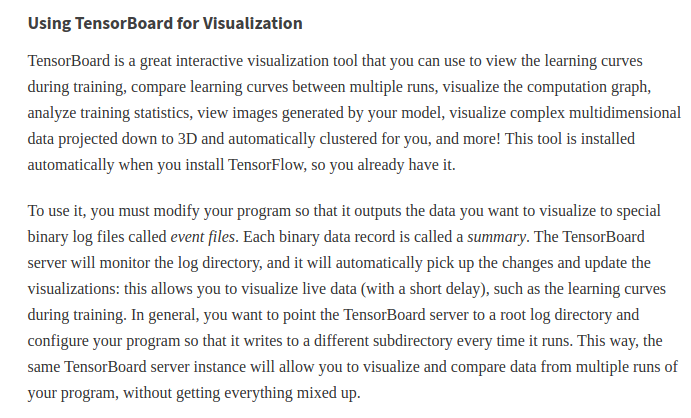

- Let’s start by defining the root log directory we will use for our TensorBoard logs, plus a small function that will generate a subdirectory path based on the current date and time so that it’s different at every run. 
- You may want to include extra information in the log directory name, such as hyperparameter values that you are testing, to make it easier to know what you are looking at in TensorBoard.

In [11]:
root_logdir = os.path.join(os.curdir,"my_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir,run_id)

run_logdir = get_run_logdir() # e.g., './my_logs/run_2019_06_07-15_15_22'


### We can use callback in Keras to use access TensorBoard features

In [12]:
#Defining and compiling a model for demo 
input_ = keras.layers.Input(shape=X_train_set.shape[1:])
hidden1 = keras.layers.Dense(20, activation="relu")(input_)
output_ = keras.layers.Dense(1)(hidden1)
dummy_model = keras.Model(inputs=input_,outputs=output_)
dummy_model.compile(loss="mse", optimizer="sgd")

#defining an instance of TensorBoard callback class with folder to save log files
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history_tb_cb = dummy_model.fit(X_train_set, Y_train_set, epochs=20,
                               validation_data=(X_validn,Y_validtn),
                               callbacks=[tensorboard_cb])

Epoch 1/20
363/363 [==============================] - 2s 5ms/step - loss: 1.0922 - val_loss: 0.5561
Epoch 2/20
363/363 [==============================] - 2s 4ms/step - loss: 0.5179 - val_loss: 0.4902
Epoch 3/20
363/363 [==============================] - 1s 4ms/step - loss: 0.4929 - val_loss: 0.4722
Epoch 4/20
363/363 [==============================] - 2s 4ms/step - loss: 0.4455 - val_loss: 0.4623
Epoch 5/20
363/363 [==============================] - 2s 4ms/step - loss: 0.4321 - val_loss: 0.5171
Epoch 6/20
363/363 [==============================] - 1s 4ms/step - loss: 0.4344 - val_loss: 0.4472
Epoch 7/20
363/363 [==============================] - 2s 5ms/step - loss: 0.4819 - val_loss: 0.4455
Epoch 8/20
363/363 [==============================] - 1s 4ms/step - loss: 0.4442 - val_loss: 0.4389
Epoch 9/20
363/363 [==============================] - 1s 4ms/step - loss: 0.4112 - val_loss: 0.4391
Epoch 10/20
363/363 [==============================] - 2s 5ms/step - loss: 0.4075 - val_loss: 0.4636

- There’s one directory per run, each containing one subdirectory for training logs and one for validation logs.
- Both contain event files, but the training logs also include profiling traces: this allows TensorBoard to show you exactly how much time the model spent on each part of your model, across all your devices, which is great for locating performance bottlenecks.

__Next you need to start the TensorBoard server.__
- One way to do this is by running a command in a terminal. If you installed TensorFlow within a virtualenv, you should activate it. Next, run the following command at the root of the project (or from anywhere else, as long as you point to the appropriate log directory):  
```
 tensorboard --logdir=./my_logs --port=6006
TensorBoard 2.0.0 at http://mycomputer.local:6006/ (Press CTRL+C to quit)
```
- If your shell cannot find the tensorboard script, then you must update your PATH environment variable so that it contains the directory in which the script was installed (alternatively, you can just replace tensorboard in the command line with python3 -m tensorboard.main). Once the server is up, you can open a web browser and go to http://localhost:6006.
  
- Alternatively, you can use TensorBoard directly within Jupyter, by running the following commands. The first line loads the TensorBoard extension, and the second line starts a TensorBoard server on port 6006 (unless it is already started) and connects to it:  
```
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006
```

In [13]:
#Starting the TensorBoard server
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

## Fine tuning hyperparameters
In order to fine tune hypermarameters, we wrap our keras models in objects that looks like Scikit-leran regressors. Once we do this we can use techniques we have used in `ML_mini_projects/scikit_leran_projects/housing_price_example` to tune the keras model hyperparameters.

##### We start by defining a function to build and compile our keras model(neural network).

In [14]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=6e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

- Note that the above function creates a simple enought sequential model with  n_hidden layers, number of neurons per layer and learning rate taken as parameters. Ultimately, our aim is to use these parameters as hypermaters for our tuning method.  
- Also note that we have given reasonable default values for the function parameters(hyperparameters).

Now lets wrap our keras model inside a wrapper which mimics the scikit-learn regressor.

In [15]:
keras_regressor = keras.wrappers.scikit_learn.KerasRegressor(build_model)


- Now we can use this object like a regular Scikit-Learn regressor: we can train it using its fit() method, then evaluate it using its score() method, and use it to make predictions using its predict() method.
- Note that any extra parameter you pass to the fit() method will get passed to the underlying Keras model. Also note that the score will be the opposite of the MSE because Scikit-Learn wants scores, not losses (i.e., higher should be better).


In [16]:
keras_regressor.fit(X_train_set, Y_train_set, epochs=10,
              validation_data=(X_validn, Y_validtn),
              callbacks=[keras.callbacks.EarlyStopping(patience=8)])

Epoch 1/10
363/363 [==============================] - 1s 3ms/step - loss: 1.4317 - val_loss: 1.1235
Epoch 2/10
363/363 [==============================] - 2s 4ms/step - loss: 1.4007 - val_loss: 0.6439
Epoch 3/10
363/363 [==============================] - 1s 4ms/step - loss: 0.5940 - val_loss: 0.5592
Epoch 4/10
363/363 [==============================] - 1s 4ms/step - loss: 0.5302 - val_loss: 0.5186
Epoch 5/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4873 - val_loss: 0.4912
Epoch 6/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4683 - val_loss: 0.4776
Epoch 7/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4453 - val_loss: 0.4589
Epoch 8/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4319 - val_loss: 0.4606
Epoch 9/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4225 - val_loss: 0.4436
Epoch 10/10
363/363 [==============================] - 1s 3ms/step - loss: 0.4153 - val_loss: 0.4394

In [17]:
mse_test = keras_regressor.score(X_test_set, Y_test_set)
random_input = X_test_set[5].reshape(1,8)
Y_pred = keras_regressor.predict(random_input)

162/162 [==============================] - 1s 4ms/step - loss: 0.3917


### Using scikit-learn model_selection module to do randomsearch for hyperparameters tuing.
See Chapter 2 of “Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition, by Aurélien Géron (O’Reilly). Copyright 2019 Kiwisoft S.A.S., 978-1-492-03264-9.” or the project `ML_mini_projects/scikit_leran_projects/housing_price_example` for details.

In [18]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": (0, 1, 2),
    "n_neurons": np.arange(40, 45),
    "learning_rate": reciprocal(3e-4, 3e-3),
}

rnd_search_cv = RandomizedSearchCV(keras_regressor, param_distribs, n_iter=1, cv=2)
rnd_search_cv.fit(X_train_set, Y_train_set, epochs=10,
                  validation_data=(X_validn, Y_validtn),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/10
182/182 [==============================] - 1s 5ms/step - loss: 3.4986 - val_loss: 1.8037
Epoch 2/10
182/182 [==============================] - 1s 4ms/step - loss: 1.3872 - val_loss: 1.0136
Epoch 3/10
182/182 [==============================] - 1s 4ms/step - loss: 0.9331 - val_loss: 0.8045
Epoch 4/10
182/182 [==============================] - 1s 4ms/step - loss: 0.7882 - val_loss: 0.7222
Epoch 5/10
182/182 [==============================] - 1s 4ms/step - loss: 0.7268 - val_loss: 0.6804
Epoch 6/10
182/182 [==============================] - 1s 4ms/step - loss: 0.6921 - val_loss: 0.6525
Epoch 7/10
182/182 [==============================] - 1s 5ms/step - loss: 0.6689 - val_loss: 0.6323
Epoch 8/10
182/182 [==============================] - 1s 5ms/step - loss: 0.6509 - val_loss: 0.6148
Epoch 9/10
182/182 [==============================] - 1s 5ms/step - loss: 0.6362 - val_loss: 0.6012
Epoch 10/10
182/182 [==============================] - 1s 3ms/step - loss: 0.6025
Epoch 1/10
182/182

RandomizedSearchCV(cv=2,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f5058328a30>,
                   n_iter=1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f50581b9250>,
                                        'n_hidden': (0, 1, 2),
                                        'n_neurons': array([40, 41, 42, 43, 44])})

Note that there is a __run time error__ that might pop up  because of a bug. The reason is explained here https://github.com/keras-team/keras/issues/13586.
This can temporarily fixed by commenting out a sanity check in the file 
`~/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/base.py` or wherver the related file is located. Open this file using any editor for example:
`gedit ~/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/base.py`
and then commenting out lines 96-98. Note that this bug might get fixed in the future or the aforementioned file might be modified in a future release. Use caution if this is the case.

### Choosing the best parameters and model

In [21]:
print("best parametes from random search:\n",rnd_search_cv.best_params_)
print("best score: ",rnd_search_cv.best_score_)

best_model = rnd_search_cv.best_estimator_.model

best parametes from random search:
 {'learning_rate': 0.0007827998830485957, 'n_hidden': 1, 'n_neurons': 40}
best score:  -0.6313197910785675


- Note that in practice, the fine tuning process might take hours depending on the data and parameter grid size. I have made the tuning part very short since the whole point of this exercise is educaiton and not accurately making predictions. As as result, even after hyperparameter tuning, the scores and accuracy are not that good. 
- The scores could be significantly improved by allowing the model to train longer with bigger epochs and larger hyperparameter grid size. Play around with the parameter grid to get an improved score, provided you have ample time to invest.

## Saving the best model:

In [22]:
best_model.save("./saved_models/best_model_rn_search.h5")

## Other useful hyperparameter tuning packages: 
    

- Hyperopt  
- Hyperas, kopt, or Talos  
- Keras Tuner  
- Scikit-Optimize (skopt)  
- Spearmint  
- Hyperband  
- Sklearn-Deap 

## Reasonable hyperparameters estimates (number of layer, neurons etc) to start a quick prototype.

### Number of hidden layers

- An MLP with just one hidden layer can theoretically model even the most complex functions, provided it has enough neurons.  
- But for complex problems, deep networks have a much higher parameter efficiency.  
- Shallow layer models lower structures like line segments, and deeper layers model higher structures like face.  
- Start with just one or two hidden layers and the neural network will work just fine for most problems.  
- Very complex tasks, such as large image classification or speech recognition, typically require networks with dozens of layers and they need a huge amount of training data.

### Number of neurons in each hidden layer

- In general you will get more bang for your buck by increasing the number of layers instead of the number of neurons per layer.
- The number of neurons in the input and output layers is determined by the type of input and output your task requires.
- Though its tempting to use pyramid structure for the number of neurons in subsequent layers, most efficient way would be to use same number of neurons in all the hicdden layers, which would also give make hyperparameter tuning easier.
- Sometimes its beneficial to use higher number of neurons in the first hidden layer.
- Start with a sufficiently large number of neurons in the hidden layer and use early stoppage.

### Learning rate and  batch size

__Learning rate__  
- In general, learning rate and batch size are related.  
- Learning rate is the most important hyperparameter.   
- In general, the optimal learning rate is about half of the maximum learning rate (i.e., the learning rate above which the training algorithm diverges).  
- Start with a very low learning rate (e.g., 10-5) and gradually increasing it up to a very large value (e.g., 10).  
- Plot the loss as a function of the learning rate (using a log scale for the learning rate), you should see it dropping at first. But after a while, the learning rate will be too large, so the loss will shoot back up: the optimal learning rate will be a bit lower than the point at which the loss starts to climb (typically about 10 times lower than the turning point).  

__Batch size__

- Try to use large batch size, to make use of the GPUs ability to process them efficiently in parallel.
- Using large batch size might lead to instability, so if this is the case, try to reduce the batch size. 


## End